<a href="https://colab.research.google.com/github/Jaydenzk/DS-Unit-2-Applied-Modeling/blob/master/module1/assignment_applied_modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin with baselines: majority class baseline for classification, or mean baseline for regression, with your metric of choice.
- [ ] Begin to clean and explore your data.
- [ ] Choose which features, if any, to exclude. Would some features "leak" information from the future?

## Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), **by Lambda DS3 student** Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Video_Games_Sales_as_at_22_Dec_2016.csv to Video_Games_Sales_as_at_22_Dec_2016.csv


In [44]:
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python package:
    # category_encoders, version >= 2.0
    !pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [87]:
!pip install eli5

     |████████████████████████████████| 112kB 2.7MB/s 


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

In [46]:
df.shape

(16719, 16)

In [47]:
df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [48]:
df.Platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [70]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
7,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,Nintendo,E


In [0]:
## Keep columns's name simple form

df = df.rename(columns={"Year_of_Release": "Year", "NA_Sales": "NA", "EU_Sales": "EU", "JP_Sales": "JP", "Other_Sales": "Other", "Global_Sales": "Global"})
df = df[df["Year"].notnull()]
df = df[df["Genre"].notnull()]
df["Year"] = df["Year"].apply(int)

In [72]:
df = df[(df['Platform'] == 'PS4') | (df['Platform'] == 'XOne') | (df['Platform'] == 'Wii') | (df['Platform'] == 'PC')]

#Let's double check the value counts to be sure
print(pd.value_counts(df["Platform"]))

#Let's see the shape of the data again
print(df.shape)

Wii     1286
PC       957
PS4      393
XOne     247
Name: Platform, dtype: int64
(2883, 16)


In [0]:
platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

In [73]:
from sklearn.model_selection import train_test_split

# Split into train & test sets first

X_train, X_test = train_test_split(df, train_size=0.8, test_size=0.2, 
                                  stratify=df['Genre'], random_state=42)

# Split X_train into train and val sets

X_train, X_val = train_test_split(X_train, train_size=0.8, test_size=0.2, 
                                 stratify=X_train['Genre'], random_state=42)

# Drop target column from train, validation, & test sets and set y target vectors for each
# Target is Genre on each features

target = 'Genre'
y_train = X_train[target]
y_val = X_val[target]
y_test = X_test[target]

X_train = X_train.drop(columns=target)
X_val = X_val.drop(columns=target)
X_test = X_test.drop(columns=target)

# REMEMBER: test set will not be used until the end!
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1844, 15), (1844,), (462, 15), (462,), (577, 15), (577,))

In [74]:
print('Train:\n', y_train.value_counts(normalize=True))
print('Validation:\n', y_val.value_counts(normalize=True))
print('Test:\n', y_test.value_counts(normalize=True))

Train:
 Action          0.216377
Sports          0.135033
Misc            0.115510
Shooter         0.099783
Strategy        0.075922
Simulation      0.074295
Role-Playing    0.070499
Racing          0.065618
Adventure       0.065618
Platform        0.029284
Puzzle          0.027657
Fighting        0.024403
Name: Genre, dtype: float64
Validation:
 Action          0.216450
Sports          0.134199
Misc            0.114719
Shooter         0.099567
Strategy        0.075758
Simulation      0.073593
Role-Playing    0.071429
Adventure       0.064935
Racing          0.064935
Platform        0.030303
Puzzle          0.028139
Fighting        0.025974
Name: Genre, dtype: float64
Test:
 Action          0.216638
Sports          0.135182
Misc            0.116118
Shooter         0.098787
Strategy        0.076256
Simulation      0.074523
Role-Playing    0.071057
Adventure       0.065858
Racing          0.064125
Platform        0.029463
Puzzle          0.027730
Fighting        0.024263
Name: Genre, dty

In [75]:
# Normalize y_train

y_train.value_counts(normalize=True)

Action          0.216377
Sports          0.135033
Misc            0.115510
Shooter         0.099783
Strategy        0.075922
Simulation      0.074295
Role-Playing    0.070499
Racing          0.065618
Adventure       0.065618
Platform        0.029284
Puzzle          0.027657
Fighting        0.024403
Name: Genre, dtype: float64

In [76]:
# Accuracy Score

from sklearn.metrics import accuracy_score

majority = y_train.mode()[0]
maj_pred = [majority] * len(y_train)
accuracy_score(y_train, maj_pred)

0.21637744034707157

In [83]:
Global = 'Global'
numeric = X_train.select_dtypes('number').columns.drop(Global).tolist()

for col in numeric:
    X_train[col] = X_train[col].astype('object')

print(X_train.shape)
X_train.dtypes

(1844, 15)


Name             object
Platform         object
Year             object
Publisher        object
NA               object
EU               object
JP               object
Other            object
Global          float64
Critic_Score     object
Critic_Count     object
User_Score       object
User_Count       object
Developer        object
Rating           object
dtype: object

In [79]:
for col in numeric:
    X_val[col] = X_val[col].astype('object')

print(X_val.shape)

(462, 15)


In [80]:
for col in numeric:
    X_test[col] = X_test[col].astype('object')

print(X_test.shape)

(577, 15)


In [81]:
#Random Forest

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Create ML pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

# Fit to train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.31601731601731603


In [82]:
# Let's do a permutation importance to see the most important features
# Rerun the random forest classifier outside the pipeline

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [88]:
# Let's do eli5 to see which columns to use

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, scoring='accuracy', n_iter=2, random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,  # show the permutation importances for all features
    feature_names=feature_names
)

Using TensorFlow backend.


Weight,Feature
0.0790 ± 0.0238,Rating
0.0563 ± 0.0043,Platform
0.0238 ± 0.0216,Publisher
0.0195 ± 0.0043,Developer
0.0087 ± 0.0000,Critic_Score
0.0076 ± 0.0065,Year
0.0065 ± 0.0043,User_Count
0.0054 ± 0.0108,NA
0 ± 0.0000,User_Score
-0.0011 ± 0.0195,EU


In [89]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

# Fit to train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.31601731601731603


In [90]:
from sklearn.metrics import classification_report

# Calculate y_pred
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

      Action       0.33      0.69      0.45       100
   Adventure       0.22      0.07      0.10        30
    Fighting       0.50      0.08      0.14        12
        Misc       0.31      0.36      0.33        53
    Platform       0.00      0.00      0.00        14
      Puzzle       0.00      0.00      0.00        13
      Racing       0.22      0.07      0.10        30
Role-Playing       0.12      0.06      0.08        33
     Shooter       0.29      0.13      0.18        46
  Simulation       0.31      0.24      0.27        34
      Sports       0.37      0.39      0.38        62
    Strategy       0.30      0.37      0.33        35

    accuracy                           0.32       462
   macro avg       0.25      0.20      0.20       462
weighted avg       0.28      0.32      0.27       462



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


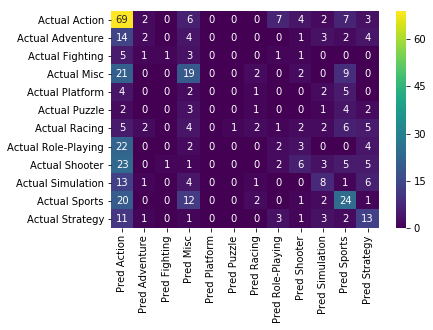

In [93]:
# Let's see the heatmap in each Genre

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Pred {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='.0f', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

False    253
True     209
dtype: int64

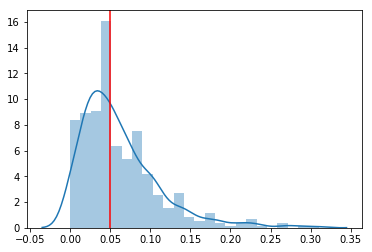

In [116]:
threshold = 0.05
ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

y_pred = y_pred_proba > threshold
pd.Series(y_pred).value_counts()

In [0]:
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

def set_threshold(y_true, y_pred_proba, threshold=0.05):
    y_pred = (y_pred_proba > threshold)
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    
interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

In [119]:
# confusion matrix for majority baseline

majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.21645021645021645

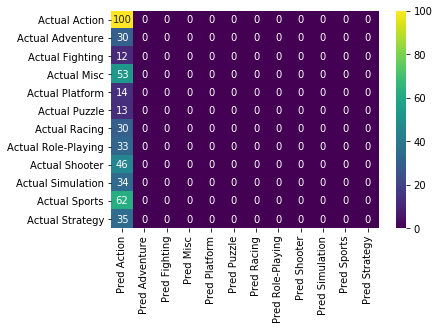

In [120]:
plot_confusion_matrix(y_val, y_pred);

In [123]:
#ROC AUC score for majority baseline

from sklearn.metrics import roc_auc_score

y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

ValueError: ignored